<a href="https://colab.research.google.com/github/vjuge/oc-iml/blob/P6/modules/P6/module_P6_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
tfds.load(name="stanford_dogs", split=["train", "test"], data_dir="gs://oc-iml-datasets01/tensorflow_datasets")

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.utils.vis_utils import plot_model
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageShow
import cv2 as cv

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from keras import backend as K
from keras.models import load_model
from tensorflow.keras import layers

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [2]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
else: print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Download Dataset

In [3]:
# tfds.disable_progress_bar()

# train_ds, validation_ds, test_ds = tfds.load(
#     "stanford_dogs",
#     # Reserve 10% for validation and 10% for test
#     split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
#     as_supervised=True
# )

train_ds, test_ds = tfds.load(
    "stanford_dogs",
    split=['train', 'test'],
    as_supervised=True
)

In [ ]:
# one-hot encode labels ?
# NUM_CLASSES=120
# train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, depth=NUM_CLASSES)))
# test_ds = test_ds.map(lambda x, y: (x, tf.one_hot(y, depth=NUM_CLASSES)))

Prepare the data : 

note: on doit resizer à 150 x 150, car si on garde 299 x 299 (default XCeption), la ram n'est pas suffisante sur collab:

```
Votre session a planté après avoir utilisé toute la RAM disponible.

En tant qu'abonné Colab Pro, vous disposez de plus de mémoire, mais si vous êtes intéressé par des environnements d'exécution à mémoire RAM encore plus élevée, envisagez de passer à Colab Pro+.
```

le fitting plante dès la fin de la première epoch

In [ ]:
size = (299, 299)

train_ds = train_ds\
    .map(lambda x, y: (tf.image.resize(x, size), y))\
        .map(lambda x, y: (x, tf.one_hot(y, depth=120))) # transform labels to one hot encoding
# validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))\
    .map(lambda x, y: (x, tf.one_hot(y, depth=120))) #depth is number of classes

In [5]:
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
#validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

In [6]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1),]
)

<Figure size 720x720 with 0 Axes>

(-0.5, 298.5, 298.5, -0.5)

(-0.5, 298.5, 298.5, -0.5)

(-0.5, 298.5, 298.5, -0.5)

(-0.5, 298.5, 298.5, -0.5)

(-0.5, 298.5, 298.5, -0.5)

(-0.5, 298.5, 298.5, -0.5)

(-0.5, 298.5, 298.5, -0.5)

(-0.5, 298.5, 298.5, -0.5)

(-0.5, 298.5, 298.5, -0.5)

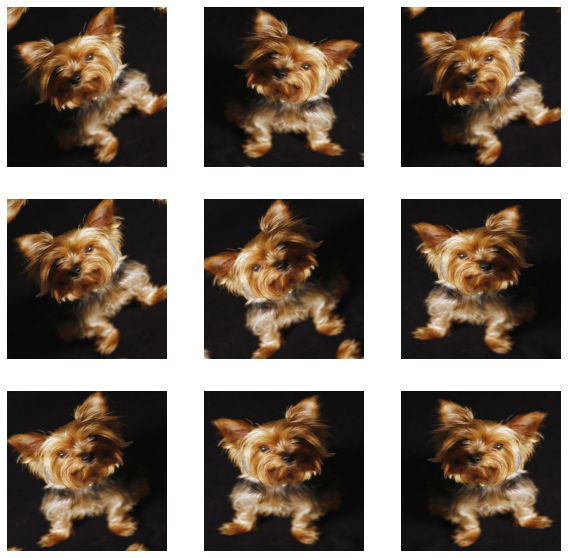

In [7]:
import numpy as np

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        # plt.title(int(labels[0]))
        plt.axis("off")

In [8]:
def plot_history_scores(dict_history, first_score, second_score):
    with plt.style.context('seaborn-whitegrid'):
        fig = plt.figure(figsize=(25,10))
        # summarize history for accuracy
        plt.subplot(1, 2, 1)
        plt.plot(dict_history.history[first_score], color="g")
        plt.plot(dict_history.history['val_' + first_score],
                 linestyle='--', color="orange")
        plt.title('CNN model ' + first_score, fontsize=18)
        plt.ylabel(first_score)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        # summarize history for loss
        plt.subplot(1, 2, 2)
        plt.plot(dict_history.history[second_score], color="g")
        plt.plot(dict_history.history['val_' + second_score],
                 linestyle='--', color="orange")
        plt.title('CNN model ' + second_score, fontsize=18)
        plt.ylabel(second_score)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()

Build model

In [9]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(299, 299, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(299, 299, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(120, activation='softmax')(x)  #120 = number of breeds
model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 299, 299, 3)       0         
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

Train top layer

In [10]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.CategoricalCrossentropy(),
    metrics=[keras.metrics.CategoricalAccuracy()],
)

epochs = 25
history = model.fit(train_ds, epochs=epochs, validation_data=test_ds)

Epoch 1/25
375/375 [==============================] - 104s 242ms/step - loss: 1.1507 - categorical_accuracy: 0.7788 - val_loss: 0.3630 - val_categorical_accuracy: 0.9026
Epoch 2/25
375/375 [==============================] - 89s 237ms/step - loss: 0.4301 - categorical_accuracy: 0.8722 - val_loss: 0.3117 - val_categorical_accuracy: 0.9044
Epoch 3/25
375/375 [==============================] - 89s 237ms/step - loss: 0.3715 - categorical_accuracy: 0.8851 - val_loss: 0.2982 - val_categorical_accuracy: 0.9050
Epoch 4/25
375/375 [==============================] - 89s 237ms/step - loss: 0.3261 - categorical_accuracy: 0.8956 - val_loss: 0.2976 - val_categorical_accuracy: 0.9045
Epoch 5/25
375/375 [==============================] - 89s 237ms/step - loss: 0.2964 - categorical_accuracy: 0.9055 - val_loss: 0.2920 - val_categorical_accuracy: 0.9034
Epoch 6/25
375/375 [==============================] - 89s 237ms/step - loss: 0.2750 - categorical_accuracy: 0.9115 - val_loss: 0.2982 - val_categorical_ac

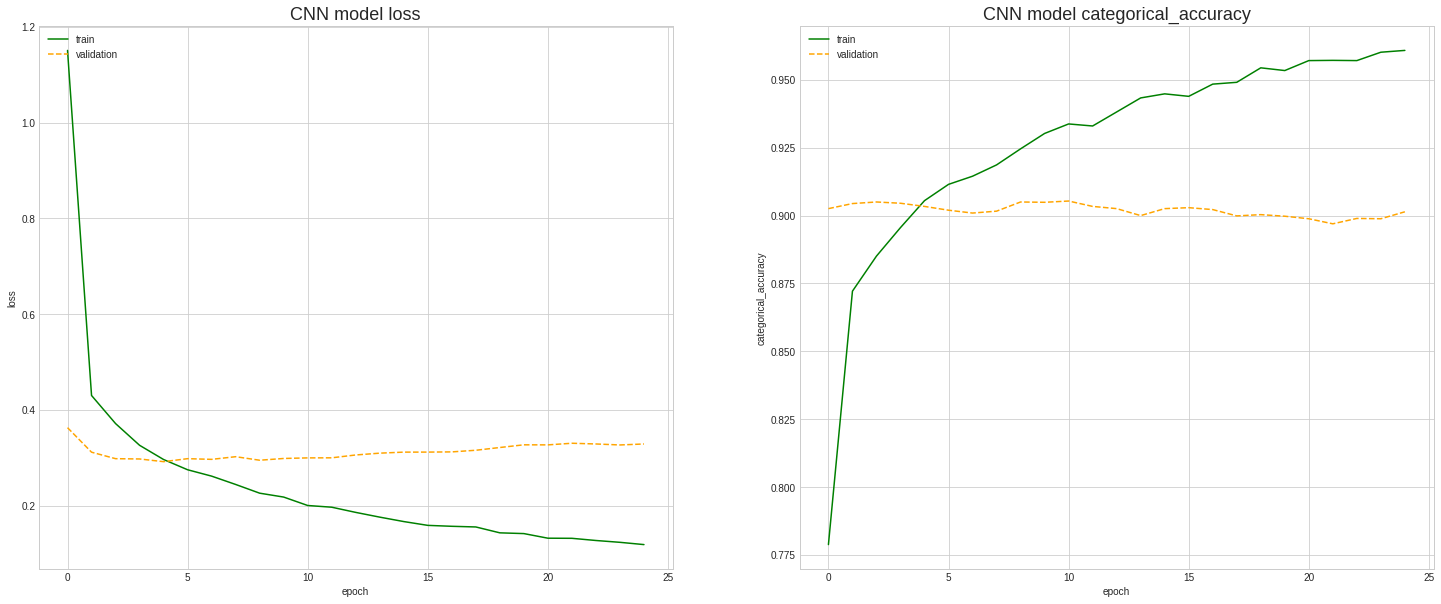

In [11]:
plot_history_scores(history, "loss", "categorical_accuracy")

In [13]:
history.model.save('xception_trained_model.h5')

In [23]:
for images, labels in train_ds.take(2):
    print("infer:")
    print(labels[0])
    print(model(images, training=False))
    print(np.argmax(model(images, training=False), axis=1))

infer:
tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(120,), dtype=float32)
tf.Tensor(
[[4.5350390e-07 3.8097152e-09 2.3724465e-07 ... 1.9431392e-08
  1.5058531e-07 1.7972779e-08]
 [1.5765675e-08 1.5248968e-08 1.0525881e-09 ... 1.3849307e-05
  9.9993563e-01 7.2241434e-08]
 [1.1938030e-11 2.7473695e-11 5.6052215e-11 ... 3.4369282e-11
  2.8099746e-11 5.0932362e-11]
 ...
 [6.2465755e-11 2.4083482e-10 4.1719661e-10 ... 3.6977183e-12
  1.2978221e-10 2.4392299e-10]
 [6.0854023e-07 8.2566496e-09 2.8527091e-07 ... 2.9613904e-07
  3.7629343e-07 2.2248397e-08]
 [2.8387141e-05 1.7970521e-08 1.9217097e-07 ... 2.7683440e-09
  1.1229461e-08 7.1024175e-10]], shape=(32,

In [ ]:
#todo use label encoder instead of tf_onehot, to have the reverse afterwards
# encoder = LabelEncoder()
# encoder.fit(y)
# y = encoder.transform(y)




Data augmentation:

<https://pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/>


### model compile

What are the choices for optimizer, loss & metrics ? : <https://keras.io/guides/training_with_built_in_methods#many-builtin-optimizers-losses-and-metrics-are-available>

* optimizers: <https://keras.io/api/optimizers/>
* Losses: <https://keras.io/api/losses/>
* Metrics: <https://keras.io/api/metrics/>



tip: in order to view GPU usage, type command: `watch -n 1 nvidia-smi`

The results are quite poor, both accuracy and loss are too low (resp. too high)

## Pre-trained model : Transfer Learning

Kera doc: <https://keras.io/guides/transfer_learning/>

deep learning with Python <https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html>

